## EXTRA CHAPTER 3 KIRK HAMMET EDGES
En este trabajo extra voy a intentar aplicar los conocimientos aprendidos en el capitulo 3 para sacar lo mejor posible los bordes de mi guitarrista favorito.

Text(0.5, 1.0, 'KIRK')

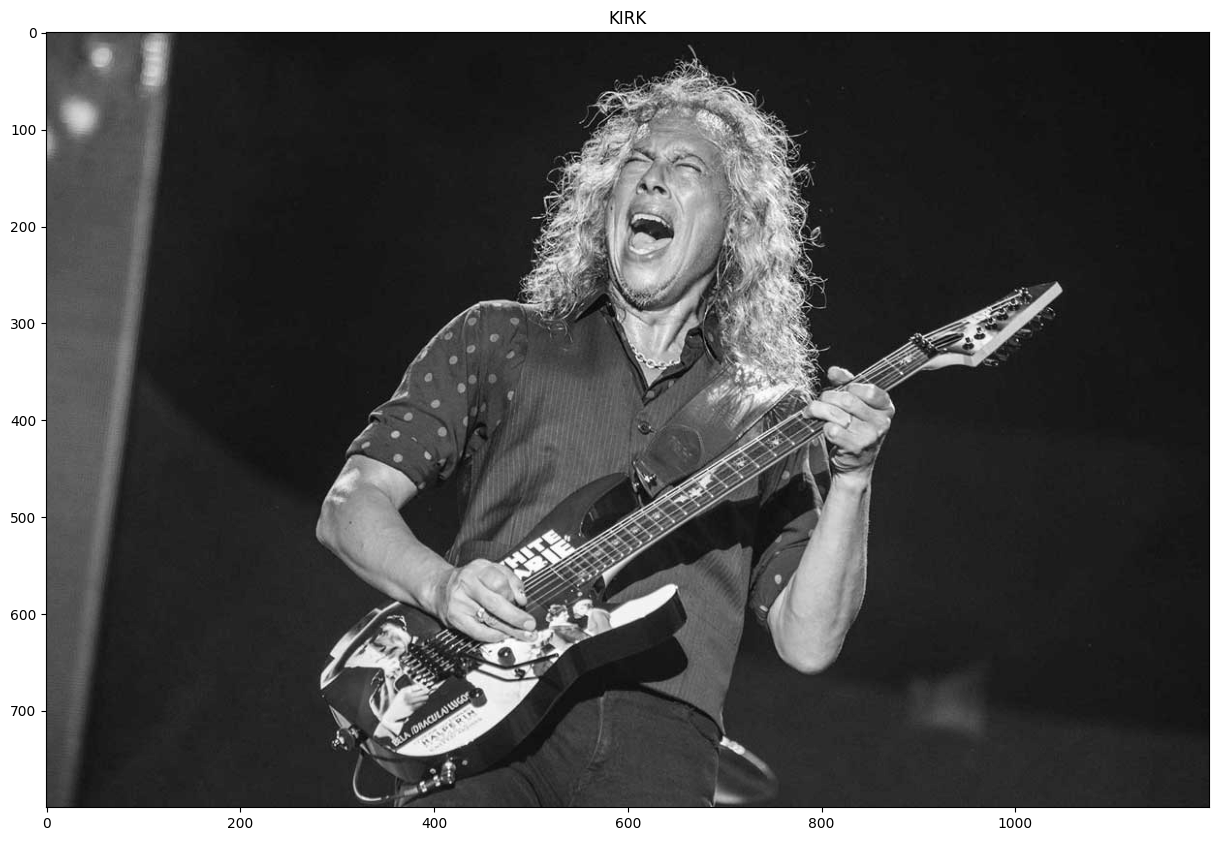

In [6]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
import math
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

image = cv2.imread('kirk.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap = 'gray')
plt.title('KIRK')

Primero usaré DroG para calcular los bordes:

In [9]:
def edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False):

    d_h = cv2.filter2D(image, cv2.CV_16S, kernel_h) # horizontal
    d_v = cv2.filter2D(image, cv2.CV_16S, kernel_v) # vertical
    
    # Compute gradient
    gradient_image = np.add(np.absolute(d_h),np.absolute(d_v)) # Hint: You have to sum both derivatives in absolute value!
    
    #Normalize gradient
    norm_gradient = np.copy(image)
    norm_gradient = cv2.normalize(gradient_image, norm_gradient, 0, 255, cv2.NORM_MINMAX)
    
    ret, edges = cv2.threshold(norm_gradient, threshold, 255,cv2.THRESH_BINARY)
    
    if verbose:
        # Show the initial image
        plt.subplot(131)
        plt.imshow(image, cmap='grey')
        plt.title('Original image')

        # Show the gradient image
        plt.subplot(132)
        plt.imshow(norm_gradient, cmap='grey')
        plt.title('Gradient image')

        # Show edges image
        plt.subplot(133)
        plt.imshow(edges, cmap='grey')
        plt.title('Edges detected')
    
    return edges

def gauss_formula(x,sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x*x) / (2*sigma*sigma))

def gaussian_kernel(image, w_kernel, sigma, threshold, verbose=False):

    s = sigma
    w = w_kernel
    gaussian_kernel_1D = np.array([gauss_formula(z,sigma) for z in range(-w,w+1)])

    vertical_kernel = gaussian_kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = gaussian_kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)   

    x = np.arange(-w,w+1)
    y = np.vstack(x)    

    DroG_h = gaussian_kernel_2D*(-x)/sigma**2 # Horizontal derivative
    DroG_v = gaussian_kernel_2D*(-y)/sigma**2 # Vertical derivative

    edge_detection_chart(image, DroG_h, DroG_v, threshold, verbose)
    
    return DroG_h, DroG_v

In [18]:
interactive(gaussian_kernel, image=fixed(image), w_kernel=(1,5,1), sigma=(0.4,5,0.5), threshold=(0,255,10), verbose=fixed(True))

interactive(children=(IntSlider(value=3, description='w_kernel', max=5, min=1), FloatSlider(value=2.4, descrip…

Vemos que ha sacado bastante bien los bordes, aunque con un poco de respuesta multiple, con los parámetros aplicados. Por lo que ahora pasaré a utilizar el algoritmo Canny:

In [41]:
def gaussian_smoothing(image, sigma, w_kernel):
    s=sigma
    w=w_kernel
    kernel_1D = np.array([gauss_formula(z,sigma) for z in range(-w,w+1)])
    
    # Apply distributive property of convolution
    vertical_kernel = kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)   
    
    # Blur image
    smoothed_img = cv2.filter2D(image,cv2.CV_8U,gaussian_kernel_2D)
    
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img, None, 0, 255, cv2.NORM_MINMAX) # Leave the second argument as None
    
    return smoothed_norm

def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    
    # Smooth image
    blurred_img = gaussian_smoothing(image,sigma,w_gaussian)
   
    
    # Apply Canny to original image
    canny = cv2.Canny(image,lower_threshold,upper_threshold)
    
    # Apply Canny to blurred image
    canny_blurred = cv2.Canny(blurred_img,lower_threshold,upper_threshold)

    # return canny_blurred
    # # Show initial image
    plt.subplot(131)
    plt.imshow(image, cmap = 'grey')
    plt.title('Original image')
    
    # # Show Canny without blurring
    plt.subplot(132)
    plt.imshow(canny, cmap= 'grey' )
    plt.title('Canny without smoothing')
    
    # # Show Canny with blurring
    plt.subplot(133)
    plt.imshow(canny_blurred, cmap= 'grey')
    plt.title('Canny smoothed')

In [43]:
interactive(canny_testing, image = fixed(image), lower_threshold=(0,180,10), upper_threshold=(0,180,10), sigma = (0,3,0.1), w_gaussian = (1,4,1))

interactive(children=(IntSlider(value=90, description='lower_threshold', max=180, step=10), IntSlider(value=90…

Aquí se puede ver lo bien que saca los bordes el algoritmo de canny. En este caso no hacia mucha falta comparar la imagen sin suavizado, contra la que si lo tiene, porque la imagen tiene muy poco ruido, pero me ha parecido interesante verlo.